In [3]:
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests
from itertools import groupby
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Загрузить BED-файл в DataFrame
df = pd.read_csv("Chr1.phylop.final.bed", sep="\t", header=0, low_memory=False)
df.head(10)

,#chr,start,end,phyloP_-log_pvalue
0,Chr1,0,1,1.946
1,Chr1,1,2,2.285
2,Chr1,2,3,2.388
3,Chr1,3,4,1.772
4,Chr1,4,5,-0.911
5,Chr1,5,6,0.978
6,Chr1,6,7,2.201
7,Chr1,7,8,-0.769
8,Chr1,8,9,2.943
9,Chr1,9,10,0.345


In [5]:
df["p_value"] = 10 ** (-abs(df["phyloP_-log_pvalue"])) # Преобразуем -log(p-value) обратно в p-value
df.head(10)

,#chr,start,end,phyloP_-log_pvalue,p_value
0,Chr1,0,1,1.946,0.011324
1,Chr1,1,2,2.285,0.005188
2,Chr1,2,3,2.388,0.004093
3,Chr1,3,4,1.772,0.016904
4,Chr1,4,5,-0.911,0.122744
5,Chr1,5,6,0.978,0.105196
6,Chr1,6,7,2.201,0.006295
7,Chr1,7,8,-0.769,0.170216
8,Chr1,8,9,2.943,0.001140
9,Chr1,9,10,0.345,0.451856


In [6]:
# Применяем FDR-коррекцию (Benjamini-Hochberg)
_, q_values, _, _ = multipletests(df["p_value"], method='fdr_bh')

# Добавляем q-values в таблицу
df["q_value"] = q_values

# Определяем значимые позиции (q ≤ 0.05)
df["significant"] = df["q_value"] <= 0.05

# Категоризация по phyloP score:
#   - phyloP > 0 → консервативный (отрицательный отбор)
#   - phyloP < 0 → ускоренный (положительный отбор)
df["constraint_type"] = np.where(
    (df["significant"]) & (df["phyloP_-log_pvalue"] > 0), "constrained",
    np.where((df["significant"]) & (df["phyloP_-log_pvalue"] < 0), "accelerated", "neutral")
)

# Вывод первых строк
df.head(20)


,#chr,start,end,phyloP_-log_pvalue,p_value,q_value,significant,constraint_type
0,Chr1,0,1,1.946,0.011324,0.051478,False,neutral
1,Chr1,1,2,2.285,0.005188,0.028709,True,constrained
2,Chr1,2,3,2.388,0.004093,0.023509,True,constrained
3,Chr1,3,4,1.772,0.016904,0.068808,False,neutral
4,Chr1,4,5,-0.911,0.122744,0.286214,False,neutral
5,Chr1,5,6,0.978,0.105196,0.257992,False,neutral
6,Chr1,6,7,2.201,0.006295,0.033039,True,constrained
7,Chr1,7,8,-0.769,0.170216,0.353132,False,neutral
8,Chr1,8,9,2.943,0.001140,0.008371,True,constrained
9,Chr1,9,10,0.345,0.451856,0.638239,False,neutral


In [7]:
# Отбираем только значимые консервативные позиции (q ≤ 0.05 и phyloP > 0)
constrained_df = df[(df["significant"]) & (df["phyloP_-log_pvalue"] > 0)]

# **1. Поиск кластеров консервативных позиций длиной ≥ 20 bp**
constrained_regions = []
for chr_name, group in constrained_df.groupby("#chr"): # разбивает constrained_df на отдельные группы по хромосомам
                                                       # group — DataFrame со всеми значимыми позициями для этой хромосомы.
    positions = group["start"].tolist() # Извлекаем список координат стартовых позиций значимых нуклеотидов.
    clusters = []
    
    # Группируем соседние позиции в кластеры
    for k, g in groupby(enumerate(positions), lambda x: x[0] - x[1]):
        cluster = list(map(lambda x: x[1], g))
        if len(cluster) >= 20:
            clusters.append((chr_name, cluster[0], cluster[-1]))

    constrained_regions.extend(clusters)

# Создаём DataFrame с консервативными регионами
conserved_regions_df = pd.DataFrame(constrained_regions, columns=["chr", "start", "end"])
conserved_regions_df.head(20)

,chr,start,end
0,Chr1,13695,13717
1,Chr1,36642,36661
2,Chr1,78931,78951
3,Chr1,130550,130577
4,Chr1,188579,188598
5,Chr1,306385,306410
6,Chr1,309274,309346
7,Chr1,332720,332740
8,Chr1,515493,515565
9,Chr1,552659,552710


In [8]:
# **2. Разбивка генома на 100-кб окна**
bin_size = 100000
bins = []

significant_df = df[(df["significant"])]

for chr_name, group in significant_df.groupby("#chr"):
    max_pos = group["end"].max()
    
    # Разделяем хромосому на 100-кб интервалыm
    for start in range(0, max_pos, bin_size):
        end = min(start + bin_size, max_pos)

        # Отбираем все позиции, попадающие в этот бин
        in_bin = group[(group["start"] >= start) & (group["end"] < end)]
        
        # Если в бине есть данные
        if not in_bin.empty:
            # Подсчёт количества позиций**
            num_conserved = (in_bin["phyloP_-log_pvalue"] > 0).sum()  # Положительные значения
            num_variable = (in_bin["phyloP_-log_pvalue"] < 0).sum()   # Отрицательные значения
            num_neutral = (end - start) - (num_conserved + num_variable) # Нейтральные значения
        else:
            num_conserved = 0
            num_variable = 0
        
        # Определение категории**
        if num_conserved > num_variable:
            category = "conserved"
        elif num_variable > num_conserved:
            category = "variable"
        else:
            category = "neutral"
        
        # Добавляем результаты в список
        bins.append((chr_name, start, end, num_conserved, num_variable, num_neutral, category))

# Создаём DataFrame с результатами
variability_df = pd.DataFrame(bins, columns=["chr", "start", "end", "num_conserved", "num_variable", "num_neutral", "category"])

# Просмотр результата 
print(variability_df.tail())

      chr     start       end  num_conserved  num_variable  num_neutral  \
300  Chr1  30000000  30100000          27234          1170        71596   
301  Chr1  30100000  30200000          24232          1600        74168   
302  Chr1  30200000  30300000          20960          1875        77165   
303  Chr1  30300000  30400000          22796          1400        75804   
304  Chr1  30400000  30427569           5628           747        21194   

      category  
300  conserved  
301  conserved  
302  conserved  
303  conserved  
304  conserved  


In [9]:
# **1. Сортируем по количеству консервативных позиций (по убыванию)**
top_conserved = variability_df.sort_values(by="num_conserved", ascending=False).head(10)
print("Топ-10 окон с наибольшим количеством консервативных позиций:")
print(top_conserved)

# **2. Сортируем по количеству вариабельных позиций (по убыванию)**
top_variable = variability_df.sort_values(by="num_variable", ascending=False).head(10)
print("\nТоп-10 окон с наибольшим количеством вариабельных позиций:")
print(top_variable)


Топ-10 окон с наибольшим количеством консервативных позиций:
      chr     start       end  num_conserved  num_variable  num_neutral  \
3    Chr1    300000    400000          28549          1219        70232   
10   Chr1   1000000   1100000          27570          1343        71087   
300  Chr1  30000000  30100000          27234          1170        71596   
7    Chr1    700000    800000          27153          1464        71383   
268  Chr1  26800000  26900000          26927          1437        71636   
299  Chr1  29900000  30000000          26213          1489        72298   
13   Chr1   1300000   1400000          25841          1318        72841   
20   Chr1   2000000   2100000          25130          1969        72901   
57   Chr1   5700000   5800000          24785          1738        73477   
54   Chr1   5400000   5500000          24702          2073        73225   

      category  
3    conserved  
10   conserved  
300  conserved  
7    conserved  
268  conserved  
299  conser

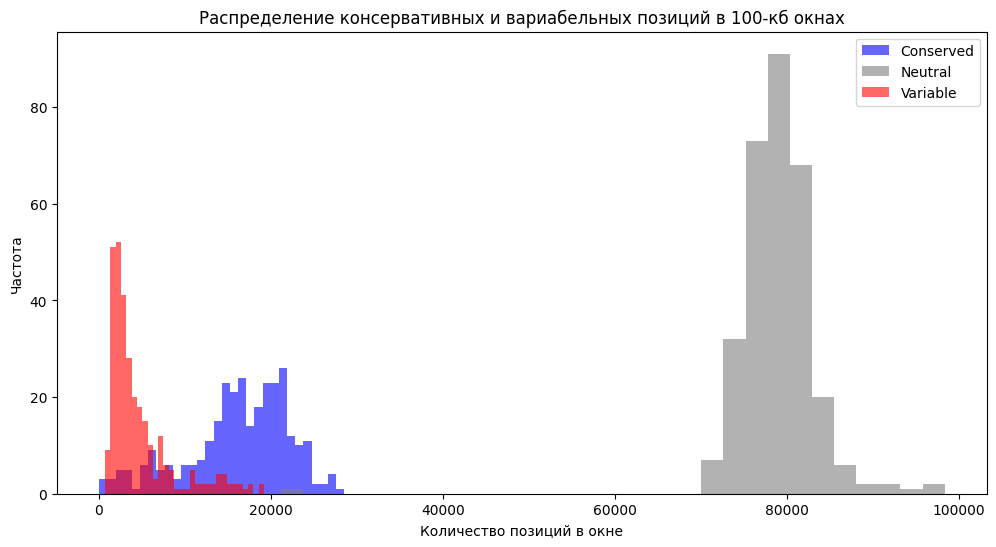

In [10]:
# **1. Гистограмма**
plt.figure(figsize=(12, 6))
plt.hist(variability_df["num_conserved"], bins=30, alpha=0.6, label="Conserved", color='blue')
plt.hist(variability_df["num_neutral"], bins=30, alpha=0.6, label="Neutral", color='gray')
plt.hist(variability_df["num_variable"], bins=30, alpha=0.6, label="Variable", color='red')
plt.xlabel("Количество позиций в окне")
plt.ylabel("Частота")
plt.title("Распределение консервативных и вариабельных позиций в 100-кб окнах")
plt.legend()
plt.show()


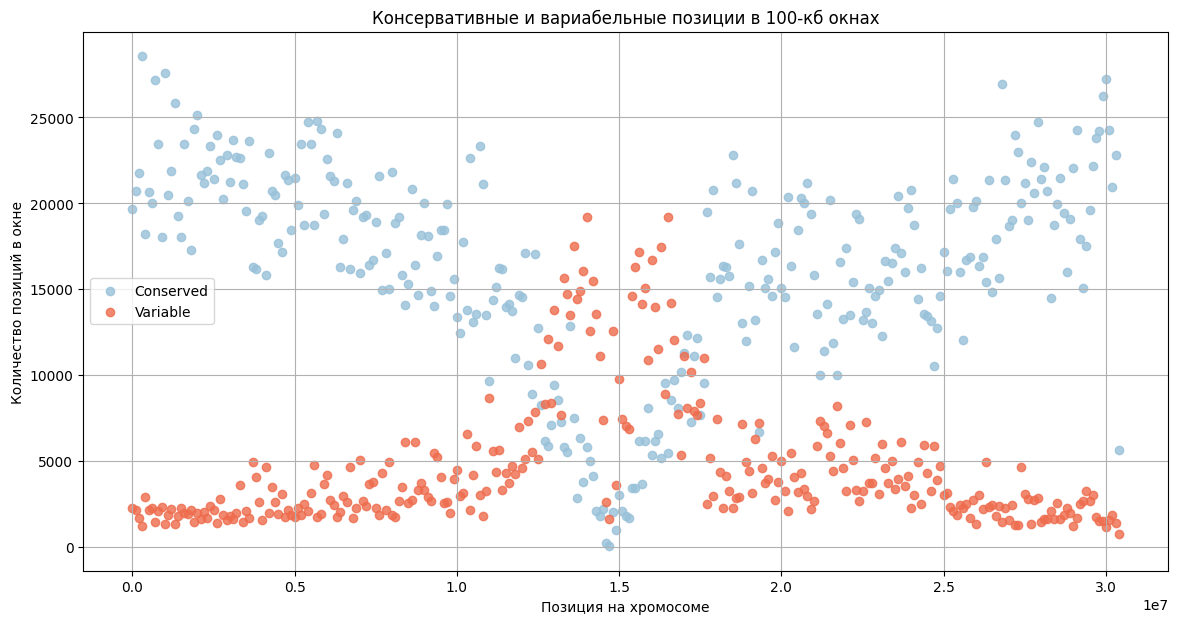

In [15]:
# 4. Точечный график: Консервативные и вариабельные позиции по окнам
plt.figure(figsize=(14, 7))

# Консервативные позиции (синие точки)
plt.scatter(variability_df["start"], 
            variability_df["num_conserved"], 
            color="#98c1d9", 
            alpha=0.8, 
            label="Conserved")

# Вариабельные позиции (красные точки)
plt.scatter(variability_df["start"], 
            variability_df["num_variable"], 
            color="#ee6c4d", 
            alpha=0.8, 
            label="Variable")

# Подписи к графику
plt.xlabel("Позиция на хромосоме")
plt.ylabel("Количество позиций в окне")
plt.title("Консервативные и вариабельные позиции в 100-кб окнах")
plt.legend()
plt.grid(True)
plt.show()


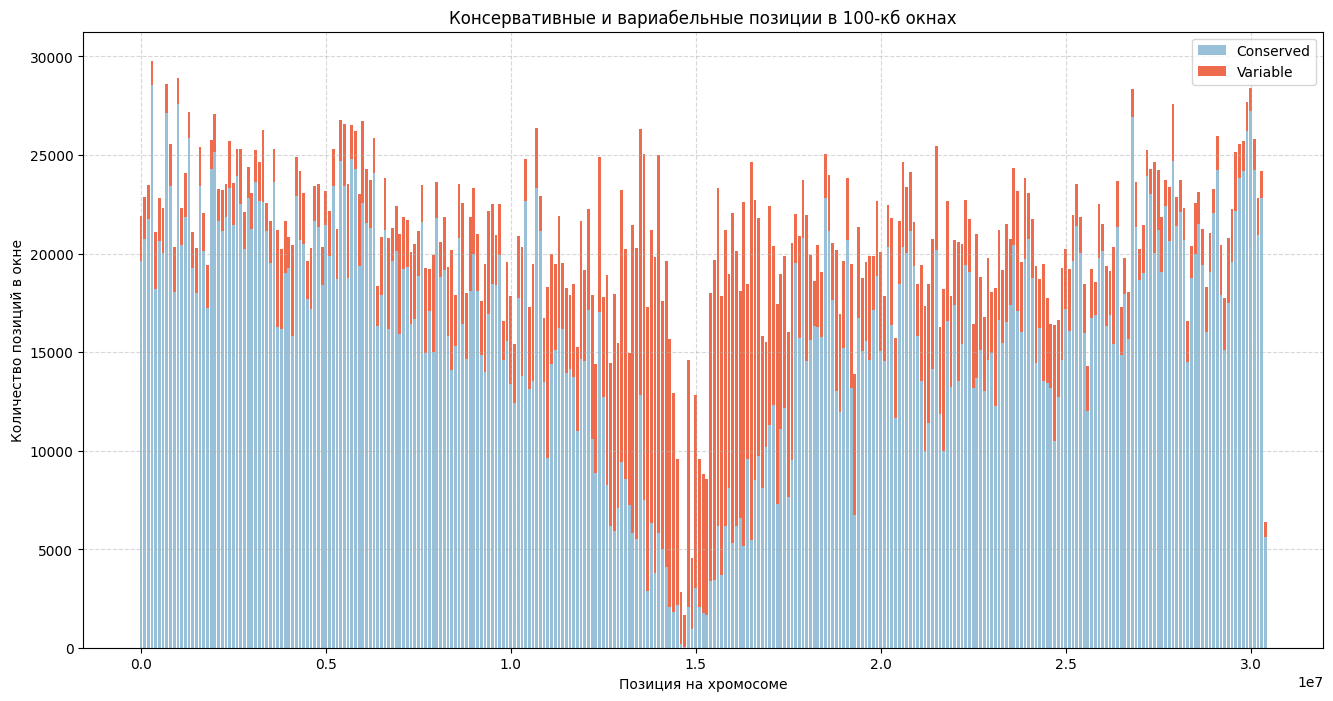

In [16]:
# Столбчатый график 
plt.figure(figsize=(16, 8))

# Сортируем данные по позиции на хромосоме
variability_df = variability_df.sort_values(by="start")

# Определяем ширину столбцов
bar_width = 75000  # От размера бина (100 кб)

# Столбчатый график: Консервативные позиции (синяя часть)
plt.bar(variability_df["start"], 
        variability_df["num_conserved"], 
        color="#98c1d9", 
        width=bar_width, 
        label="Conserved")

# Столбчатый график: Вариабельные позиции (красная часть)
plt.bar(variability_df["start"], 
        variability_df["num_variable"], 
        bottom=variability_df["num_conserved"], 
        color="#ee6c4d", 
        width=bar_width, 
        label="Variable")

# Подписи к графику
plt.xlabel("Позиция на хромосоме")
plt.ylabel("Количество позиций в окне")
plt.title("Консервативные и вариабельные позиции в 100-кб окнах")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
